<a href="https://colab.research.google.com/github/VenGr0/Generation_of_musical_works/blob/main/Music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Подготовка данных

##1.1 Загрузка и импорт билиотек

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from collections import Counter
import os

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 4
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

##1.2 Загрука и распаковка набора данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip

--2024-04-20 10:54:32--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  2.49MB/s    in 1.1s    

2024-04-20 10:54:34 (2.49 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]



In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset

##1.3 Подготовка списка файлов и нот случайного произведения Моцарта для генерации

###1.3.1 Создание списка файлов для выборки

In [ ]:
CLASS_LIST=["Chopin"]

In [ ]:
all_filepaths = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i
            all_filepaths.append(tr)

###1.3.2 Воспроизведение случайного произведения Шопена

In [ ]:
randomChopinFilepath = all_filepaths[1]
print(randomChopinFilepath)

./dataset/Chopin/chpn_op35_3.mid


In [ ]:
randomChopinMidi = pretty_midi.PrettyMIDI(randomChopinFilepath)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(randomChopinMidi)

In [ ]:
print('Количество инструментов:', len(randomChopinMidi.instruments))
instrument = randomChopinMidi.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Название инструмента:', instrument_name)

Количество инструментов: 2
Название инструмента: Acoustic Grand Piano


###1.3.3 Подготовка нот случайного произведения Моцарта для генерации музыки

In [ ]:
mozartFile = ""
count = 0
filepath = f"./dataset/Mozart/"
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        mozartFile = ""
        mozartFile = tr
        count += 1
        if(count == 2):
            break

In [ ]:
mozartSound = pretty_midi.PrettyMIDI(mozartFile)

In [ ]:
# функция преобразования MIDI в DataFrame, содержащий ноты и их расширенные параметры
def midi_to_notes(midi_file: str):
  # чтение MIDI
  pm = pretty_midi.PrettyMIDI(midi_file)
  # извлечение первого инструмента
  instrument = pm.instruments[0]

  # объявляем список для хранения нот
  notes = []
  # сортируем ноты по времени начала ноты
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

  # переменная для расчета шага, хранит предущее значение start
  prev_start = sorted_notes[0].start # начало первой ноты

  for note in sorted_notes:
    # начало ноты
    start = note.start
    # конец ноты
    end = note.end
    notes.append(
        dict(
            pitch=note.pitch,             # имя ноты
            start=note.start,             # начало ноты
            end=note.end,                 # конец ноты
            step=(start - prev_start),    # шаг
            duration=(end - start)        # длительность ноты
        )
    )

    prev_start = start # запоминаем значение предыдущего старта

  return pd.DataFrame(notes) # функция возвращает значение DataFrame библиотеки pandas

In [ ]:
mozart_raw_notes = midi_to_notes(mozartFile)
mozart_raw_notes.head()

,pitch,start,end,step,duration
0,70,0.000000,1.415762,0.000000,1.415762
1,67,0.000000,1.415762,0.000000,1.415762
2,67,1.415762,2.076846,1.415762,0.661084
3,63,1.415762,2.076846,0.000000,0.661084
4,65,2.076846,2.737930,0.661084,0.661084


##1.4 Создание и фильтрация общего набора нот

###1.4.1 Создание набора нот

In [ ]:
Corpus = []
for f in all_filepaths:
  notes = midi_to_notes(f)
  Corpus.append(notes)

Corpus = pd.concat(Corpus)

In [ ]:
Corpus = Corpus.set_index(pd.Index(range(1,len(Corpus)+1)))

In [ ]:
n_notes = len(Corpus)
print('Количество нот в корпусе:', n_notes)

Количество нот в корпусе: 40305


###1.4.2 Фильтрация редко используемых нот

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(Corpus['pitch'])
sample_note_names[:10]

array(['F5', 'D#5', 'C#5', 'F4', 'G#4', 'C#5', 'F5', 'A#5', 'G#5', 'E5'],
      dtype='<U3')

In [ ]:
count_num = Counter(sample_note_names)

In [ ]:
print('Количество уникальных нот в корпусе:', len(count_num))

Количество уникальных нот в корпусе: 72


In [ ]:
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемая нота встречается:', max(Recurrence), 'раз')
print('Наиболее редкая нота встречается:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 559.7916666666666
Наиболее часто встречаемая нота встречается: 2094 раз
Наиболее редкая нота встречается: 1 раз


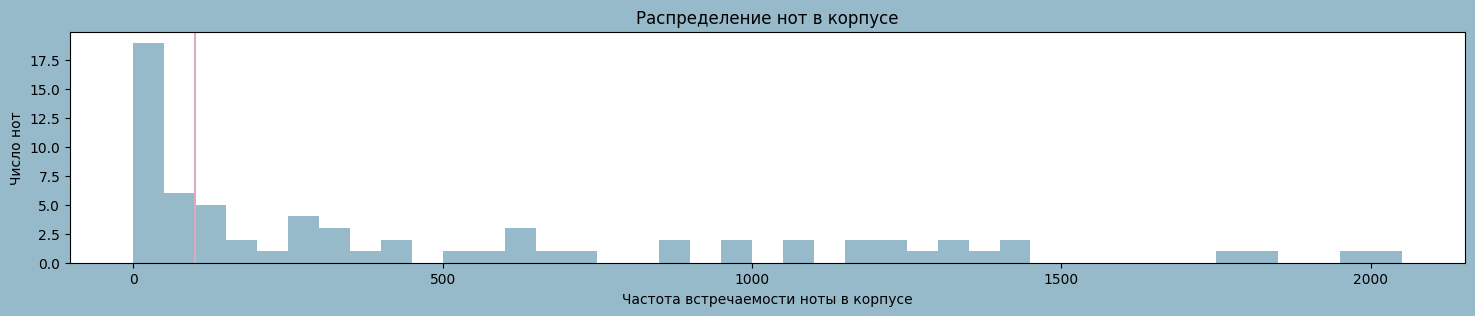

In [ ]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [ ]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 25


In [ ]:
i = 1
for element in sample_note_names:
    if element in rare_note:
        Corpus = Corpus.drop(index=i)
    i += 1

n_notes = len(Corpus)
print("Длина корпуса после исключения редких нот:", n_notes)

Длина корпуса после исключения редких нот: 39539


##1.5 Подготовка данных для обучения модели

###1.5.1 Создание тензора с параметрами участвующими в обучении

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([Corpus[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

###1.5.2 Разбиение тензора на временные ряды методом скользящего окна

На этом шаге выполняется нормализация значения высоты ноты. Остальные значения не принимают больших значений, поэтому для первичного тестирования модели выполняется нормализация только высоты ноты.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    seq_length = seq_length+1

    windows = dataset.window(seq_length, shift=1, stride=1,
                                drop_remainder=True)

    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
    print('форма последовательности:', seq.shape)
    print('первые 10 элементов последовательности:', seq[0: 10])
    print()
    print('метка:', target)

форма последовательности: (25, 3)
первые 10 элементов последовательности: tf.Tensor(
[[0.6015625  0.         1.83667979]
 [0.5859375  1.83667979 0.6185565 ]
 [0.5703125  0.6185565  0.95416775]
 [0.5078125  0.95416775 0.33757638]
 [0.53125    0.33757638 2.44397492]
 [0.5703125  2.44397492 0.6       ]
 [0.6015625  0.6        0.63576992]
 [0.640625   0.63576992 2.11672025]
 [0.625      2.11672025 0.3154575 ]
 [0.59375    0.3154575  0.3061225 ]], shape=(10, 3), dtype=float64)

метка: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=75.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.07575756250000154>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07575756250000154>}


###1.5.3 Формирование групп для обучения модели

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

#2 Создание и обучение модели

##2.1 Создание модели

Для шага и длительности используется пользовательская функция потерь, основанная на средней квадратичной ошибке, для поощрения генерации моделью не отрицательных значений.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(256)(inputs)
tf.keras.layers.Dense(128)(x)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 256)                  266240    ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    257       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  32896     ['lstm_1[0][0]']              
                                                                                            

##2.2 Оптимизация значения потерь

Общее значение потерь вычисляется как сумма всех потерь. Потери для знаечния высоты ноты, значительно выше чем остальные значения. Поэтому для оптимизации общего значения потерь рекомендуется уменьшить значение весов для потерь высоты ноты.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

617/617 [==============================] - 26s 40ms/step - loss: 5.6392 - duration_loss: 0.2061 - pitch_loss: 4.8481 - step_loss: 0.5850


{'loss': 5.639204978942871,
 'duration_loss': 0.20613349974155426,
 'pitch_loss': 4.848066806793213,
 'step_loss': 0.5850064754486084}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

617/617 [==============================] - 26s 40ms/step - loss: 1.0335 - duration_loss: 0.2061 - pitch_loss: 4.8481 - step_loss: 0.5850


{'loss': 1.0335431098937988,
 'duration_loss': 0.20613349974155426,
 'pitch_loss': 4.848066806793213,
 'step_loss': 0.5850064754486084}

##2.3 Обучение модели

Перед обучением задаются обратные вызовы для сохранения лучших весов модели, а также для остановки обечения в случае стагнации процесса, с дальнейшим восстановлением лучших весов полученных в процессе обучения.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
617/617 [==============================] - 73s 114ms/step - loss: 0.5980 - duration_loss: 0.1098 - pitch_loss: 3.6750 - step_loss: 0.3044
Epoch 2/50
617/617 [==============================] - 69s 112ms/step - loss: 0.5736 - duration_loss: 0.1025 - pitch_loss: 3.5186 - step_loss: 0.2952
Epoch 3/50
617/617 [==============================] - 67s 109ms/step - loss: 0.5682 - duration_loss: 0.1034 - pitch_loss: 3.5257 - step_loss: 0.2885
Epoch 4/50
617/617 [==============================] - 71s 115ms/step - loss: 0.5515 - duration_loss: 0.0983 - pitch_loss: 3.3667 - step_loss: 0.2849
Epoch 5/50
617/617 [==============================] - 67s 109ms/step - loss: 0.5397 - duration_loss: 0.0969 - pitch_loss: 3.2327 - step_loss: 0.2811
Epoch 6/50
617/617 [==============================] - 69s 111ms/step - loss: 0.5337 - duration_loss: 0.0951 - pitch_loss: 3.1631 - step_loss: 0.2804
Epoch 7/50
617/617 [==============================] - 67s 109ms/step - loss: 0.5280 - duration_loss: 0.093

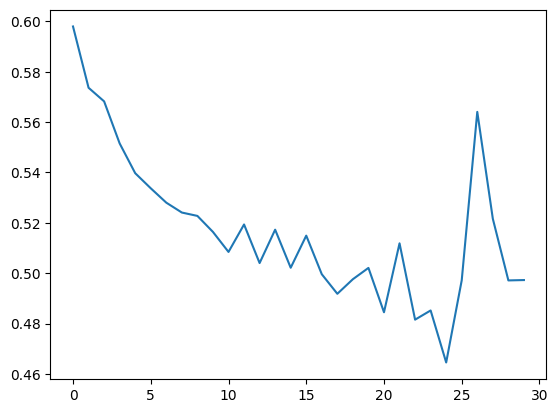

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='общие потери')
plt.show()

#3 Генерация музыки

##3.1 Определение функции генерации музыки и вспомогательных функций

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:

    assert temperature > 0

    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
      start = float(prev_start + note['step'])
      end = float(start + note['duration'])
      note = pretty_midi.Note(
          velocity=velocity,
          pitch=int(note['pitch']),
          start=start,
          end=end,
      )
      instrument.notes.append(note)
      prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
      title = f'Первые {count} нот'
    else:
      title = f'Полный файл'
      count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Время (сек.)')
    plt.ylabel('Уровень')
    _ = plt.title(title)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

##3.2 Генерация с температурой 2

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([mozart_raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 51ms/step


In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,52,0.000000,0.907009,0.000000,0.907009
1,78,1.716516,0.098508,1.716516,1.815024
2,91,1.704648,0.217417,3.421164,3.638581
3,84,1.829410,0.088864,5.250574,5.339438
4,85,1.767254,0.207776,7.017828,7.225604
5,91,1.818587,0.079769,8.836415,8.916185
6,90,1.739122,0.168698,10.575538,10.744235
7,85,1.787117,0.159064,12.362655,12.521718
8,85,1.767758,0.153383,14.130412,14.283796
9,88,1.667942,0.190064,15.798354,15.988419


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

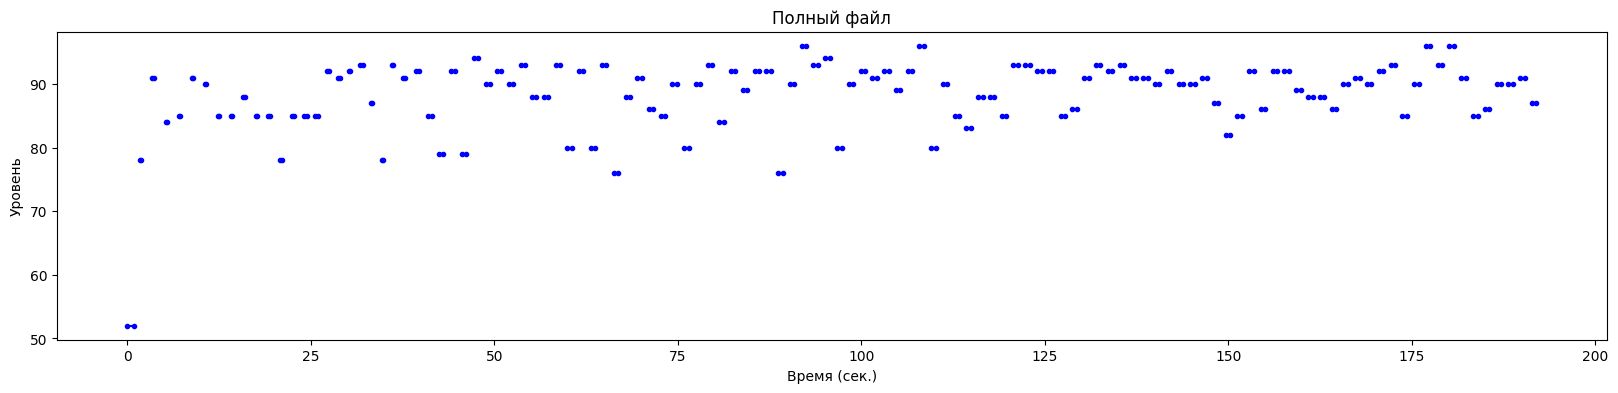

In [ ]:
plot_piano_roll(generated_notes)

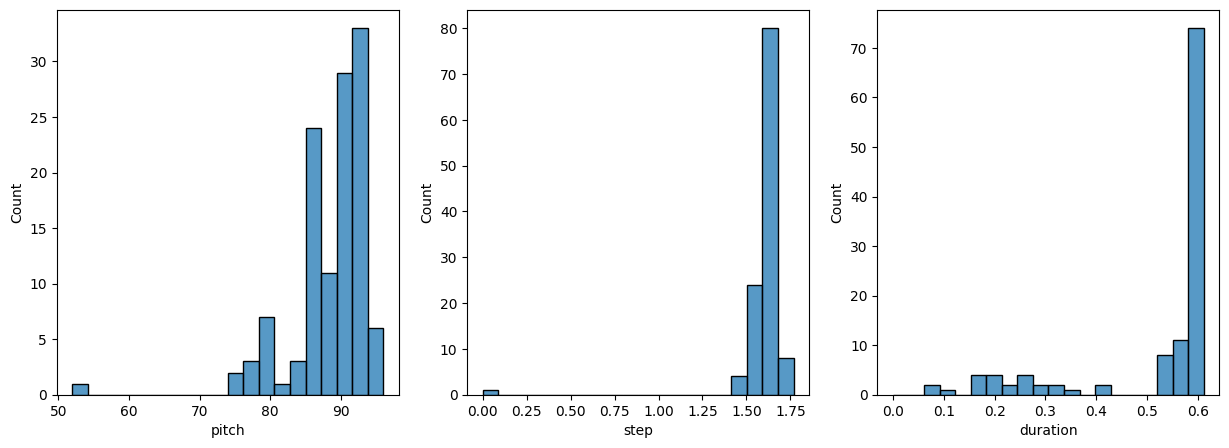

In [ ]:
plot_distributions(generated_notes)

##3.3 Генерация с температурой 10

In [ ]:
temperature = 10.0
num_predictions = 120

sample_notes = np.stack([mozart_raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 30ms/step


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

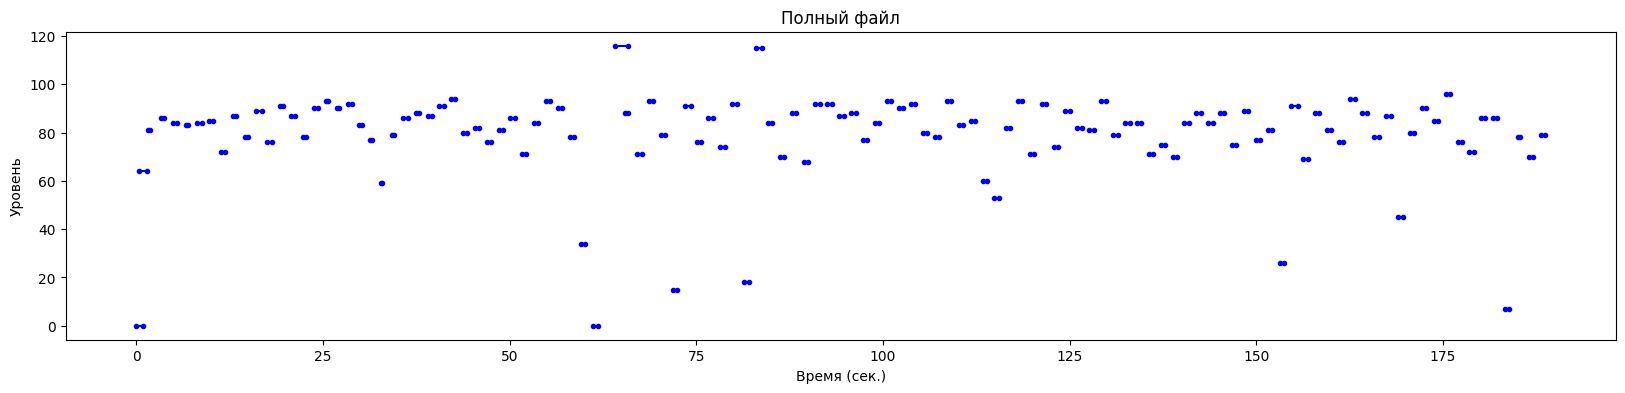

In [ ]:
plot_piano_roll(generated_notes)

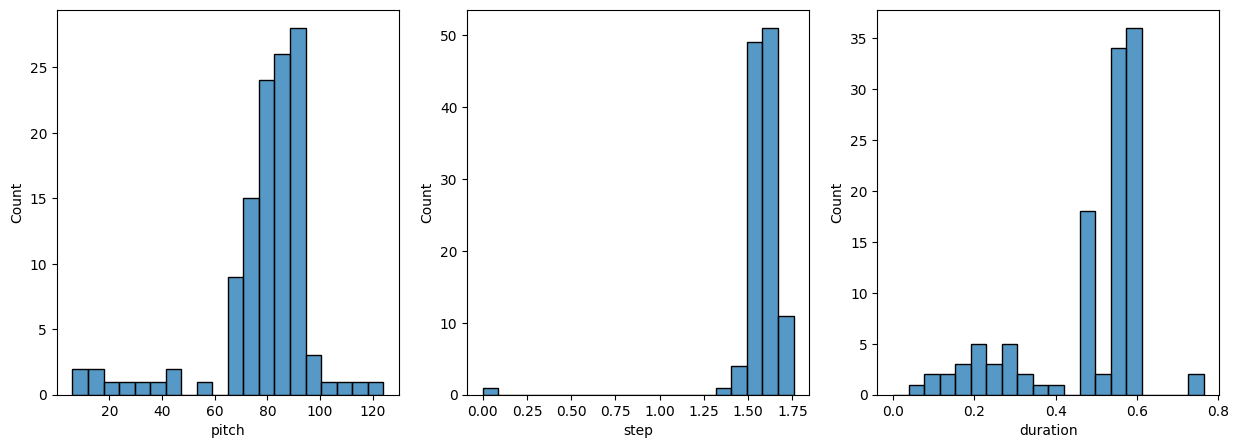

In [ ]:
plot_distributions(generated_notes)

##3.4 Выводы по работе

В результате получена модель предсказывающая ноту на основе 24-х предыдущих нот. Ноты представлены в виде их характеристики уровня, длительности и шага. Также в функцию генерации добавлен параметр температуры, отвечающий за точность генерации музыки. Результаты генерации мелодий с разной температурой действительно сильно отличаются друг от друга и результат с более высокой температурой действительно выглядит более случайным чем с низкой.